# Perform MintPy Time Series Analysis

*Author: Alex Lewandowski; Alaska Satellite Facility*

This notebook assumes that you have loaded a time series into MintPy and have prepared a custom configuration file.


**MintPy Workflow**
<p align="left">
  <img width="600" src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/MintPyWorkflow.jpg">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

- Blue Ovals: correcting unwrapping errors and inverting for the raw phase time-series
- Green Ovals: correcting for noise from different sources to obtain the displacement time-series
- Dashed Ovals: Optional Steps

---
## 0. Import Required Software


In [1]:
import base64
import contextlib
import csv
from datetime import datetime, timedelta
from getpass import getpass
import os
from pathlib import Path
import re
import shutil
from typing import Union
import zipfile

import h5py
from ipyfilechooser import FileChooser
import numpy as np
from osgeo import gdal, osr
gdal.UseExceptions()

from pandas.core.frame import DataFrame
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import transform_bounds, transform
import rioxarray as rxr
from tqdm.notebook import tqdm
import urllib
import xarray as xr

from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.models import LabelSet, Div
import bokeh.layouts

import ipywidgets as widgets
from ipywidgets import Layout

from mintpy.cli import view, tsview, plot_network, plot_transection, plot_coherence_matrix
import mintpy.plot_coherence_matrix
import mintpy.objects.insar_vs_gps
import mintpy.utils

import opensarlab_lib as osl

---
# 1. Select your project's custom config file

- This is located in your project's `MintPy` directory
- It is a text file named after your project
  - `path/to/MinPy/my_project.txt`

In [3]:
path = Path.home()
fc = FileChooser(path)
print("Select your project's MintPy directory:")
display(fc)

Select your project's MintPy directory:


FileChooser(path='/home/jovyan', filename='', title='', show_hidden=False, select_desc='Select', change_desc='…

In [4]:
config_path = Path(fc.selected)
mint_path = config_path.parent
inputs_path = mint_path / 'inputs'
ifgram_path = inputs_path / 'ifgramStack.h5'
plot_path = mint_path / 'plots'

---
## 2. Modify the Network

**Run the `modify_network` step**

- Identifies and excludes interferograms (i.e. affected by remaining coherence phase-unwrapping errors) before the network inversion
- Updates metadata with changes to your custom config

In [5]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep modify_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:46:43.450778--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
    mintpy.troposphericDelay.method: auto --> no
copy burst_test.txt       to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy burst_test.txt       to pic      directory for backup.
copy smallbaselineApp.cfg to pi

---
## 3. Plot the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- `ifgramStack_coherence_spatialAvg.txt`: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- `Network.pdf`: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. 
- `CoherenceMatrix.pdf` shows the avergae coherence pairs between all available pairs in the stack.

read temporal/spatial baseline info from file: /home/jovyan/burst_test2/MintPy/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['waterMask.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 9
number of interferograms: 8
shift all perp baseline by -34.095088958740234 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 8
number of acquisitions marked as drop: 0
max perpendicular baseline: 129.68 m
max temporal      baseline: 24.0 days
showing coherence
data range: [0.331, 0.8546]
display range: (0.2, 1.0)
showing ...


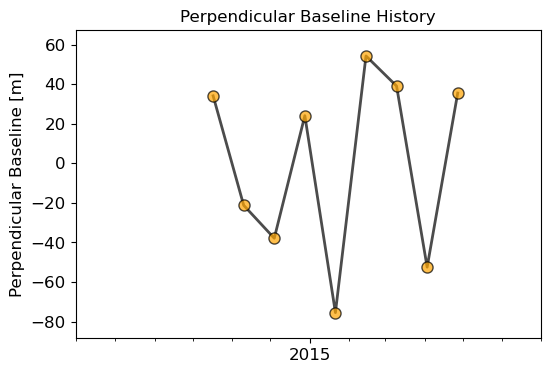

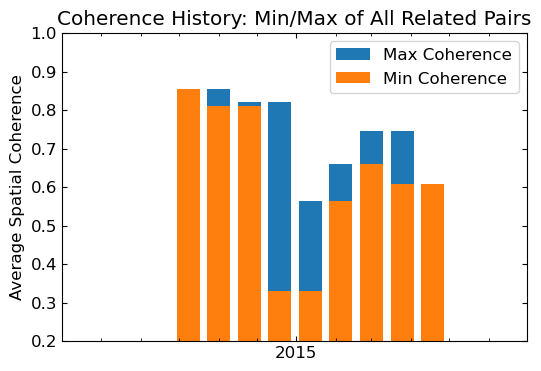

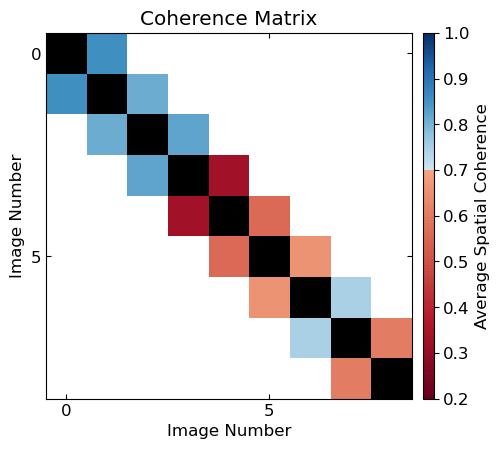

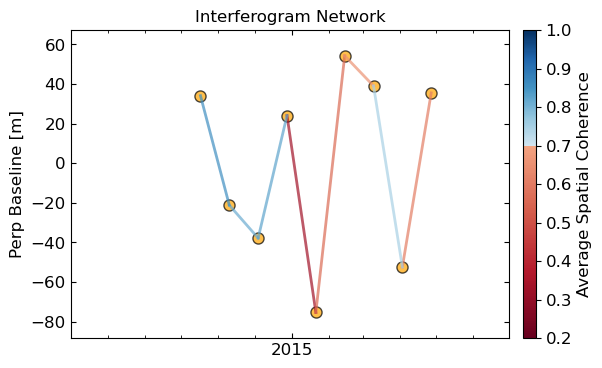

In [6]:
%matplotlib inline
with osl.work_dir(mint_path):
    scp_args = f'{inputs_path}/ifgramStack.h5 --cmap-vlist 0.2 0.7 1.0'
    plot_network.main(scp_args.split())
    plots = ['bperpHistory.pdf', 'coherenceHistory.pdf', 'coherenceMatrix.pdf', 'network.pdf']
    for p in plots:
        if (mint_path/p).exists():
            (mint_path/p).rename(f'{plot_path}/{p}')

---
## 4. Set the Reference Point

**Run the `reference_point` step**

The interferometric phase is a relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore, we need to reference all interferograms to a common reference pixel.

The `reference_point` step selects a common reference pixel for the stack of interferograms. The default approach of MintPy is to choose a pixel with the highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel. 

In [7]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_point

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:46:59.019670--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - reference_point ********************
Input data seems to be geocoded. Loo

**Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the `ifgramStack.h5` file. To see the attributes of the file run `info.py`**

In [8]:
!info.py $inputs_path/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                      6320360.0
  REF_LON                      457720.0
  REF_X                        798
  REF_Y                        276


---
## 5. Run a Quick Overview

**Run the `quick_overview` step**

- Assess possible groud deformation using the velocity from traditional interferogram stacking 
    - *reference: Zebker et al. (1997, JGR)*
- Assess distribution of phase unwrapping error from the number of interferogram triplets with non-zero integer ambiguity of closure phase 
    - *reference: T_int in Yunjun et al. (2019, CAGEO). Related to section 3.2, equation (8-9) and Fig. 3d-e.*

In [9]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep quick_overview

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:47:04.912050--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - quick_overview ********************
Input data seems to be geocoded. Lookup file not needed.

---
## 6. Inverting the Small Baseline network

**Run the `invert_network` step**

- Invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date
- By default mintpy selects the first acquisition
- The estimated time-series is converted to distance change from radar to target and is provided in meters.

In [10]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep invert_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:47:09.293918--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - invert_network ********************
Input data seems to be geocoded. Lookup file not needed.

ifgram_inversion.py /home/jovyan/burst_t

---
## 7. Correct for Tropospheric Propagation Delays (Optional)


<div class="alert alert-warning">
<font face="Calibri" size="5"><b><font color='rgba(200,0,0,0.2)'> <u>CDS is preparing to launch a new website and current service is impacted</u></font></b></font>
<br/>
<font face="Calibri" size="4">   February 14, 2024
</font>
<br/>
<font face="Calibri" size="3"><a href="https://forum.ecmwf.int/t/a-new-cds-soon-to-be-launched-expect-some-disruptions/1607">https://forum.ecmwf.int/t/a-new-cds-soon-to-be-launched-expect-some-disruptions/1607</a>
    <br/><br/>
<i><b>Expect:</b>
    <ul>
<li>longer queues</li>
<li>requests being cancelled</li>
<li>temporary closure of queues</li>
<li>requests failing with unusual error messages</li>
<li>catalogue temporarily offline</li>
</font>
</div>

**Run the `correct_troposphere` step**

***This will be skipped if `mintpy.troposphericDelay.method` is set to "no" in your custom config***

- Requires configuring a `.cdsapirc` file for CDS access
  - Run the `CDS_Access.ipynb` (Set Up Climate Data Store Access) Notebook
- Uses ECMWF [ERA5 climate reanalysis pressure data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20)%20AND%20(%20%22Provider:%20Copernicus%20C3S%22%20))&text=pressure)

In [11]:
era5_path = mint_path/"ERA5"
timeseries_era5_path = mint_path/"timeseries_ERA5.h5"
inputs_era5_path = mint_path/"inputs/ERA5.h5"

for f in [timeseries_era5_path, inputs_era5_path]:
    try:
        f.unlink()
    except FileNotFoundError:
        pass
try:
    shutil.rmtree(era5_path)
except FileNotFoundError:
    pass

!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_troposphere

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:47:15.961340--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['correct_troposphere']
Remaining steps: ['deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - correct_troposphere ********************
Input data seems to be geocoded. Lookup file not needed.
No tropospheric delay correction.
Go back to directory: /home/jovyan/opensarlab_Mint

---
## 8. Correct for DEM Errors

**Run the `correct_topography` step**

In [12]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep correct_topography

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:51:31.579810--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - correct_topography ********************
Input data seems to be geocoded. Lookup file not needed.

dem_error.py /home/jovyan/burst_test2/MintPy/timeseries.h5 -t /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg -o

## 9. Calculate the Root Mean Square (RMS) of Residual Phase Time-Series for Each Acquisition

**Run the `residual_RMS` step**

- *reference: Yunjun et al. (2019, section 4.9 and 5.4)*
- To remove the long wavelength component in space, a phase ramp is removed for each acquisition
- Sets optimal reference date to date with min RMS
- Sets exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)

In [13]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep residual_RMS

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:52:05.564449--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - residual_RMS ********************

timeseries_rms.py timeseriesResidual.h5 -t /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read options from template file: smallbaselineApp.cfg
remove quadratic ramp from file: timeseriesResidual.

## 10. Reference the Entire Time-Series to One Date in Time

**Run the `reference_date` step**

- *reference: Yunjun et al. (2019, section 4.9)*

In [14]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep reference_date

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:53:02.280785--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - reference_date ********************

reference_date.py -t /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg /home/jovyan/burst_test2/MintPy/timeseries.h5 /home/jovyan/burst_test2/MintPy/timeseries_demErr.h5
read reference date from file: reference_da

## 11. Estimate The Long-Term Velocity Rate

**Run the `velocity` step**

The timeseries file contains three datasets:
- the `time-series` dataset, which is the interferometric range change for each acquisition relative to the reference acquisition
- the `date` dataset, which contains the acquisition date for each acquisition
- the `bperp` dataset, which contains the timeseries of the perpendicular baseline 

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. 

In [16]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep velocity

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-13 23:53:31.969115--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /home/jovyan/burst_test2/MintPy/timeseries_demErr.h5 -t /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg -o /home/jovyan/burst_test2/MintPy/velocity.h5 --update
read options from template file: smallbaselineApp.cf

**Plot the velocity map**

Note: The min/max values in this plot should be adjusted to your data set. 

The output of the following call will show a data range. You can run the cell once to collect this information and re-run it after adjustments are made.

- You should update `vmin` and `vmax` to match your data range
- The `vmin` and `vmax` values that you assign will be used for additional plots in this notebook
- If you wish to set 0 deformation to the center of the color scale (green), adjust your min/max values so they are symmetrical
    - For example, given a data range of `[-10.691118, 13.904866]`, appropriate symmetrical min/max values would be `[-14.0, 14.0]` 

In [20]:
colormap_select = osl.select_parameter(
    [
        "Display red for uplift, and blue for subsidence",
        "Display blue for uplift, and red for subsidence"
    ]
)
display(colormap_select)

RadioButtons(layout=Layout(min_width='800px'), options=('Display red for uplift, and blue for subsidence', 'Di…

run view.py in MintPy version 1.5.3, date 2023-11-23
input file is velocity file: /home/jovyan/burst_test2/MintPy/velocity.h5 in float32 format
file size in y/x: (472, 1144)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1144, 472)
subset coverage in y/x: (0, 0, 1144, 472)
data   coverage in lat/lon: (393840.0, 6342480.0, 485360.0, 6304720.0)
subset coverage in lat/lon: (393840.0, 6342480.0, 485360.0, 6304720.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
update mode: ON
read mask from file: maskTempCoh.h5
reading data ...
masking data
masking pixels with NO_DATA_VALUE of 0.0
data    range: [-14.173861, 32.24824] cm/year
display range: [-32.0, 32.0] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imsho

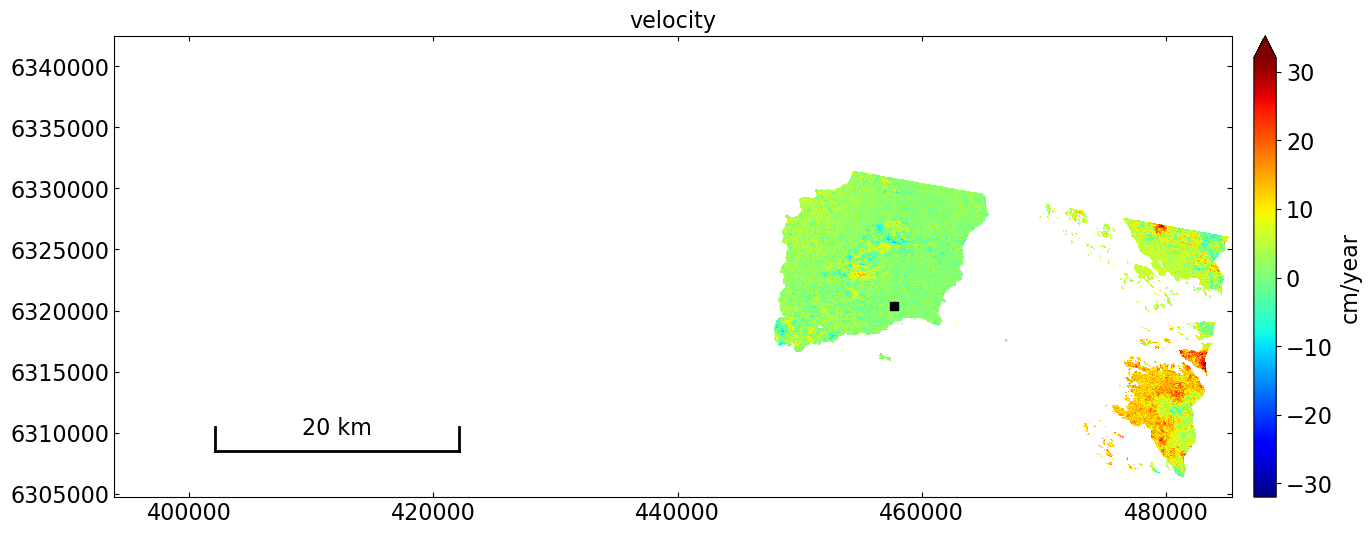

In [38]:
%matplotlib inline
cmap = 'jet' if 'red for uplift' in colormap_select.value else 'jet_r'

vel_vmin = -32
vel_vmax = 32

scp_args = f'{mint_path}/velocity.h5 velocity -v {vel_vmin} {vel_vmax} --dpi 600 --figsize 15 15 --outfile {plot_path}/velocity.png --update --colormap {cmap}'
view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

---
## 12. Geocode velocity.h5 in Preparation for Creating a velocity.kmz

**Run the `geocode` step**

- This is unnecessary for geocoded HyP3 data but would be needed for non-geocoded data

In [25]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep geocode

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-14 00:01:38.057142--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['geocode']
Remaining steps: ['google_earth', 'hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - geocode ********************
dataset is geocoded, skip geocoding and continue.
Go back to directory: /home/jovyan/opensarlab_MintPy_Recipe_Book

################################################
   Normal end of smallbaselineApp processing!
###########################################

---
## 13. Create a kmz File

**Run the `google_earth` step**

In [26]:
!smallbaselineApp.py $config_path --work-dir {mint_path} --dostep google_earth

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-14 00:01:58.445867--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Project name: burst_test
Go to work directory: /home/jovyan/burst_test2/MintPy
read custom template file: /home/jovyan/burst_test2/MintPy/burst_test.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/burst_test2/MintPy/smallbaselineApp.cfg


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded velocity file: ...

save_kmz.py /home/jovyan/burst_test2/MintPy/velocity.h5 -o /home/jovyan/burst_test2/MintPy/velocity.kmz
data   coverage in y/x: (0, 0, 1144, 472)
subset coverage in y/x: (0, 0, 1144, 472)
update L

## 14. Plot the unwrapped inverted timeseries

In [35]:
geotiff_path = mint_path / 'GeoTiffs'
disp_path = geotiff_path / 'displacement_maps'
unwrapped_path = disp_path / 'unwrapped'
unwrapped_path.mkdir(parents=True, exist_ok=True)
ts_demErr_path = list(mint_path.glob('timeseries*_demErr.h5'))[0]

run view.py in MintPy version 1.5.3, date 2023-11-23
input file is timeseries file: /home/jovyan/burst_test2/MintPy/timeseries_demErr.h5 in float32 format
file size in y/x: (472, 1144)
num of datasets in file timeseries_demErr.h5: 9
datasets to exclude (0):
[]
datasets to display (9):
['timeseries-20141017', 'timeseries-20141110', 'timeseries-20141204', 'timeseries-20141228', 'timeseries-20150121', 'timeseries-20150214', 'timeseries-20150310', 'timeseries-20150403', 'timeseries-20150427']
data   coverage in y/x: (0, 0, 1144, 472)
subset coverage in y/x: (0, 0, 1144, 472)
data   coverage in lat/lon: (393840.0, 6342480.0, 485360.0, 6304720.0)
subset coverage in lat/lon: (393840.0, 6342480.0, 485360.0, 6304720.0)
------------------------------------------------------------------------
colormap: jet
figure title: timeseries_demErr
figure size : [15.00, 15.00]
dataset number: 9
row     number: 5
column  number: 2
figure  number: 1
read mask from file: maskTempCoh.h5
------------------------

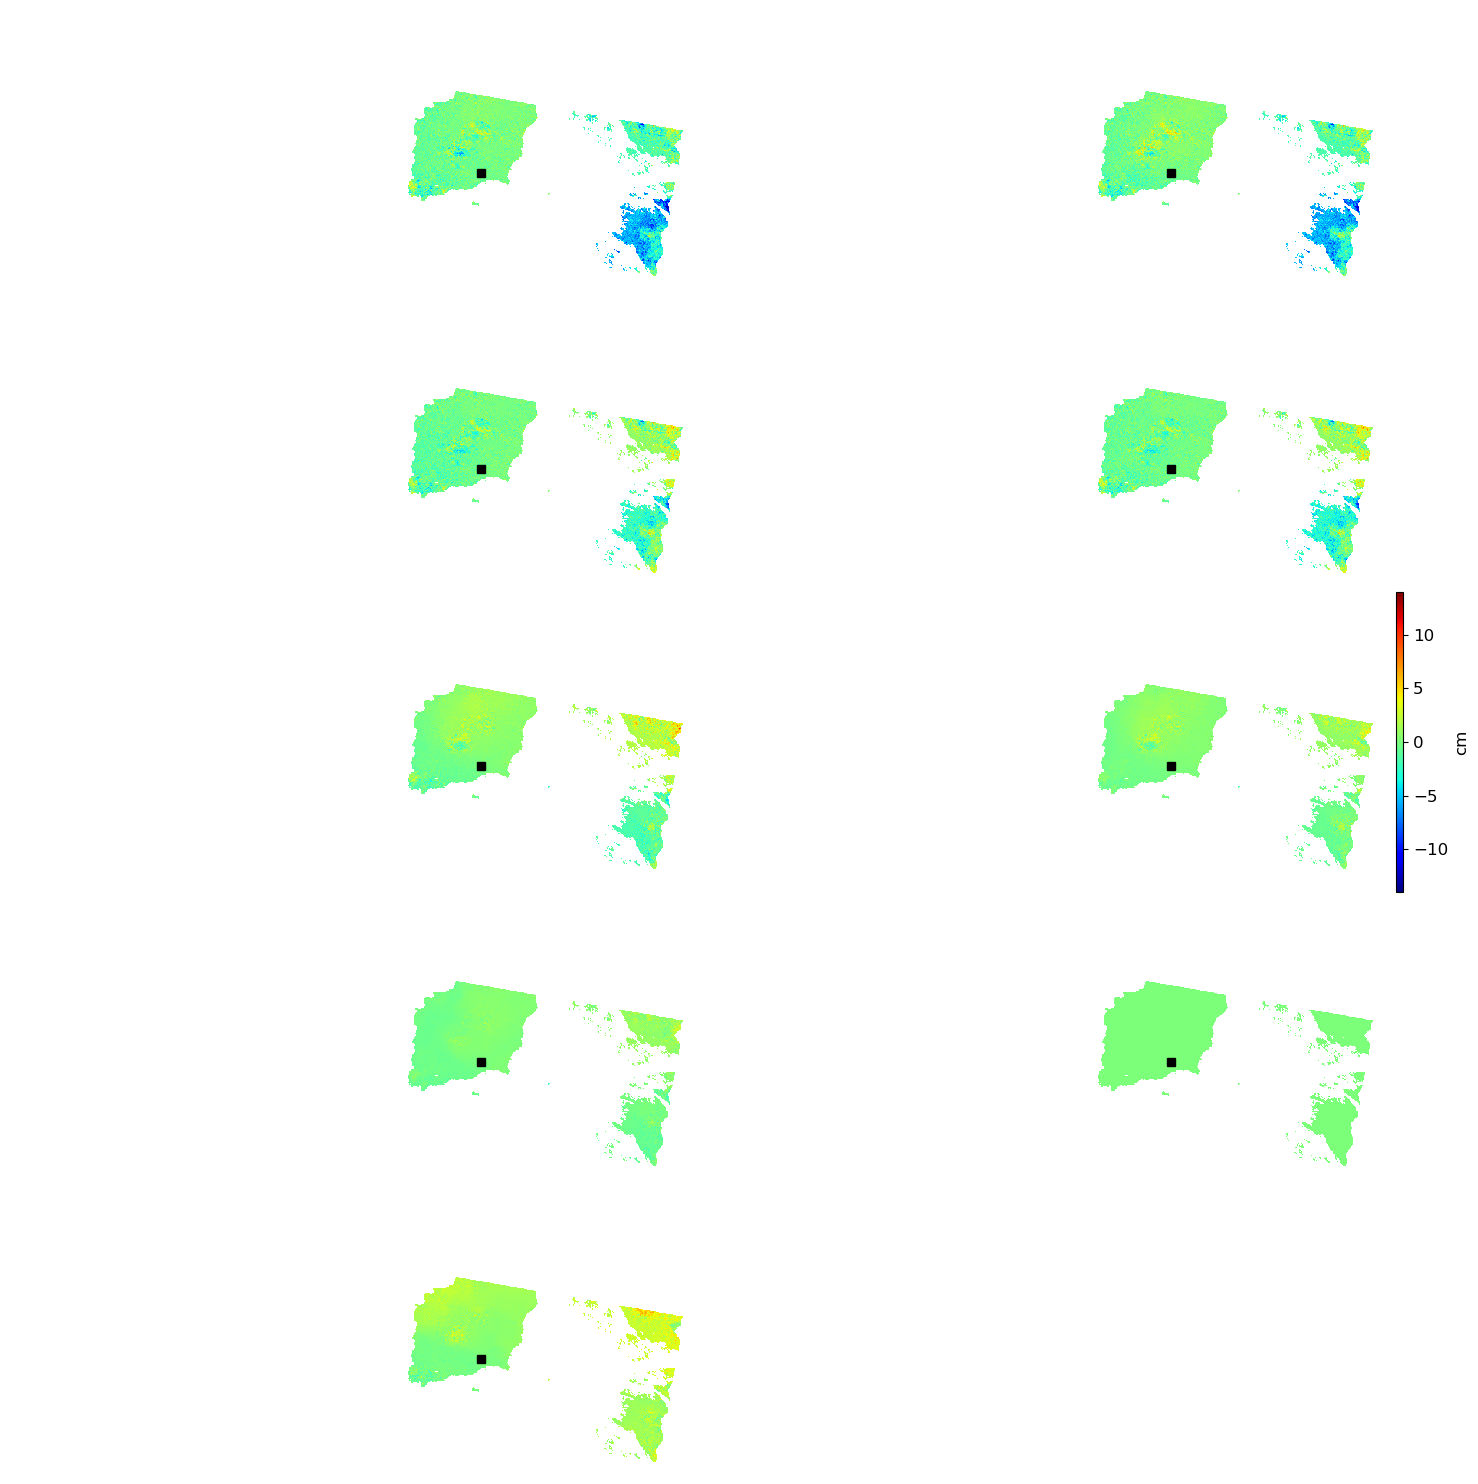

In [40]:
inv_vmin = -14
inv_vmax = 14

scp_args = f'{ts_demErr_path} --notitle --notick --noaxis -v {inv_vmin} {inv_vmax} --dpi 600 --figsize 15 15 --outfile {unwrapped_path}/unwrapped_inverted_ts.png'
view.main(scp_args.split())

# 15. Plot the Cumulative Displacement Map and Point Displacement Time Series

- Use the `Time` bar below the Cumulative Displacement Map to view displacements for different time periods
- Click on the Cumulative Displacement Map to select points for displaying Point Displacement Time-Series

tsview.py /home/jovyan/burst_test2/MintPy/timeseries_demErr.h5 -d=/home/jovyan/burst_test2/MintPy/inputs/geometryGeo.h5 -o=/home/jovyan/burst_test2/MintPy/displacement_ts --outfile=/home/jovyan/burst_test2/MintPy/displacement_ts.pdf
open timeseries file: timeseries_demErr.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 1144, 472)
subset coverage in y/x: (0, 0, 1144, 472)
data   coverage in lat/lon: (393840.0, 6342480.0, 485360.0, 6304720.0)
subset coverage in lat/lon: (393840.0, 6342480.0, 485360.0, 6304720.0)
------------------------------------------------------------------------
reference point in y/x: (276, 798)
reference point in lat/lon: (6320360.0, 457720.0)
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
reading timeseries from file /home/jovyan/burst_test2/MintPy/timeseries_demErr.h5
reference t

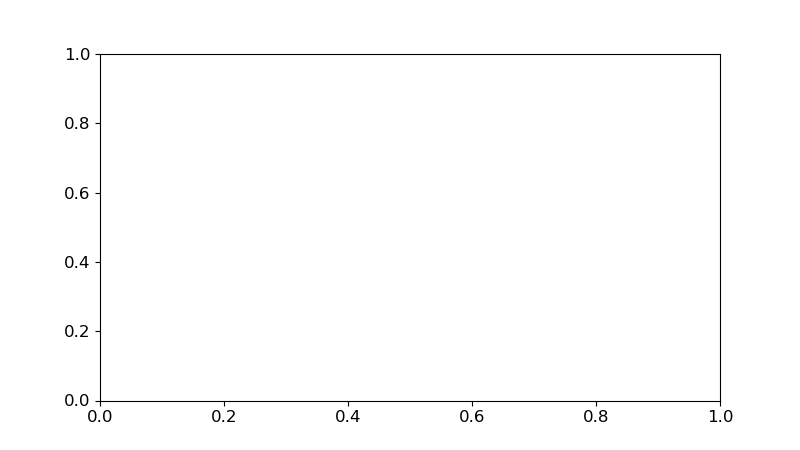

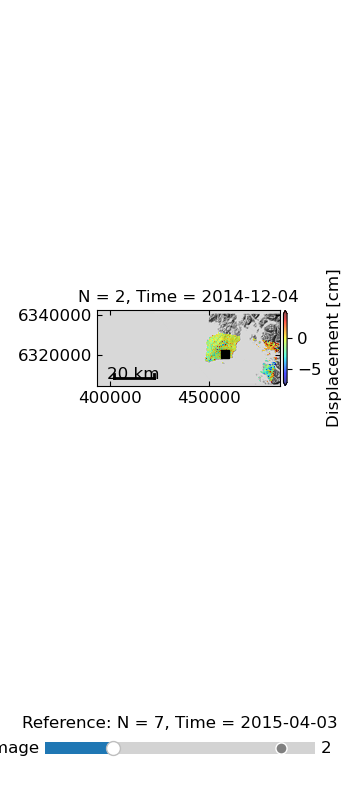

In [42]:
%matplotlib widget

tsview.main([str(ts_demErr_path),
             f'-d={mint_path}/inputs/geometryGeo.h5', 
             f'-o={mint_path}/displacement_ts', 
             f'--outfile={mint_path}/displacement_ts.pdf'])